In [1]:
from __future__ import print_function

# https://qiita.com/kzkadc/items/e4fc7bc9c003de1eb6d0
# argument Parser
import argparse

import os
import random
import math
import torch
import torch.nn as nn
#import torch.legacy.nn as lnn # do not use?
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision 
#from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

# visdom is visualize the process of learning
# torchsummary is network summarizing tool
# both are usefull!
# https://qiita.com/yasudadesu/items/1dda5f9d1708b6d4d923
#
import visdom

from torch.autograd import Variable

In [2]:
# initial setting
opt = {'dataset':'folder',
       'dataroot':'celebA/img_align_celeba/',
       'workers':0,
       'batchSize':64,
       'imageSize':64,
       'nz':512,
       'ngf':64,
       'ndf':64,
       'niter':25,
       'saveInt':5,
       'lr':0.0002,
       'beta1':0.5,
       'cuda':True,
       'ngpu':1,
       'netG': '', # if you continue, input the path
       'netD': '', # if you continue, input the path
       'outf':'./output_model',
       'manualSeed':462528}

# iptの値の一部をグローバル変数に格納
ngpu = int(opt['ngpu']) # GPUの数
nz = int(opt['nz']) # 潜在変数のベクトル長 デフォルトは100
ngf = int(opt['ngf']) # デフォルトは64
ndf = int(opt['ndf']) # デフォルトは64
nc = 3 # チャンネル数は3で固定

In [3]:
# 引数にmanualSeedが渡された場合の処理
# https://qiita.com/chat-flip/items/4c0b71a7c0f5f6ae437f
if opt['manualSeed'] is None:
    opt['manualSeed'] = random.randint(1, 10000) # manualSeedがNoneの場合、1~10000の間の一様乱数から整数を取得してseedにする
print("Random Seed: ", opt['manualSeed']) # 設定されたseedをprint

Random Seed:  462528


In [4]:
attr_list = []

# ファイルをオープンする
test_data = open('./celebA/list_attr_celeba.txt', "r")

# 一行ずつ読み込んでは表示する
i = 0
for line in test_data:
    if i == 1:
        name = line.split()
    if i >= 2:
        out = line.split()
        attr_list.append(out)
    i += 1

# ファイルをクローズする
test_data.close()

In [5]:
# ref : https://tips-memo.com/pytorch-dataset
# define transform
transform=transforms.Compose([
    transforms.Resize(opt['imageSize']),
    transforms.CenterCrop(opt['imageSize']),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


from skimage import io
from sklearn.model_selection import train_test_split
from PIL import Image

# define dataset
# https://qiita.com/sheep96/items/0c2c8216d566f58882aa
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, csv_file_path, root_dir, transform=None):
        #csvデータの読み出し
        self.image_attr_list = attr_list
        self.root_dir = root_dir
        #画像データへの処理
        self.transform = transform

    def __len__(self):
        return len(self.image_attr_list)

    def __getitem__(self, idx):
        #dataframeから画像へのパスとラベルを読み出す
        #label = self.image_dataframe.iat[idx, LABEL_IDX]
        img_name = os.path.join(self.root_dir,
                                self.image_attr_list[idx][0])
        #画像の読み込み
        image = io.imread(img_name)
        PIL_image = Image.fromarray(image)
        #画像へ処理を加える
        if self.transform:
            image = self.transform(PIL_image)

        return image, self.image_attr_list[idx][0], self.image_attr_list[idx]
    
imgDataset = MyDataset(attr_list, opt['dataroot'], transform=transform)

#train_data, test_data = train_test_split(imgDataset, test_size=0.2)

#print(train_data)

In [6]:
# dataloaderの定義
dataloaders = torch.utils.data.DataLoader(imgDataset, batch_size=opt['batchSize'],
                                          shuffle=True, num_workers=opt['workers'])

64 torch.Size([64, 3, 64, 64])


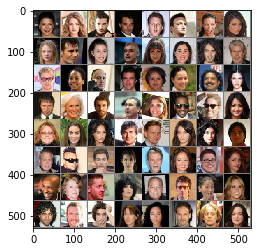

('191271.jpg', '069460.jpg', '180197.jpg', '100923.jpg', '193617.jpg', '111955.jpg', '198025.jpg', '019667.jpg', '149725.jpg', '029197.jpg', '114863.jpg', '192703.jpg', '055050.jpg', '010712.jpg', '135363.jpg', '064896.jpg', '056280.jpg', '126647.jpg', '123733.jpg', '012784.jpg', '157228.jpg', '130654.jpg', '054288.jpg', '107550.jpg', '011201.jpg', '089630.jpg', '037104.jpg', '129999.jpg', '106666.jpg', '047569.jpg', '075143.jpg', '074155.jpg', '046491.jpg', '155653.jpg', '150193.jpg', '179786.jpg', '085754.jpg', '032099.jpg', '026012.jpg', '142807.jpg', '099738.jpg', '004477.jpg', '031022.jpg', '033410.jpg', '173359.jpg', '156552.jpg', '014841.jpg', '138689.jpg', '013257.jpg', '139729.jpg', '028865.jpg', '082478.jpg', '069553.jpg', '023426.jpg', '175389.jpg', '148661.jpg', '157870.jpg', '024004.jpg', '127211.jpg', '177189.jpg', '137970.jpg', '064943.jpg', '115900.jpg', '151095.jpg')
[('191271.jpg', '069460.jpg', '180197.jpg', '100923.jpg', '193617.jpg', '111955.jpg', '198025.jpg', '01

In [7]:
# 読み込んだ画像を表示する

# 読み込み関数を定義
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0)) # 入力のテンソルをnumpy形式に変換してC*H*Wの並びからH*W*Cの並びに変換する
    mean = np.array([0.5, 0.5, 0.5]) # 後で標準化したデータをもとに戻すために使う平均値を格納
    std = np.array([0.5, 0.5, 0.5]) # 後で標準化したデータをもとに戻すために使う標準偏差を格納
    inp = std * inp + mean # 標準化したデータをもとに戻す
    inp = np.clip(inp, 0, 1) # 最小0、最大1の範囲にデータを収める https://note.nkmk.me/python-numpy-clip/
    plt.imshow(inp) # matplotlibで画像を表示　http://pynote.hatenablog.com/entry/matplotlib-imshow
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# dataloaderをイテレータオブジェクトにしてnextの要素を格納する
inputs = next(iter(dataloaders)) #https://algorithm.joho.info/programming/python/iter-next-py/

#print(inputs)
# inputs画像を使ってグリッドを生成する
out = torchvision.utils.make_grid(inputs[0]) # https://blog.shikoan.com/torchvision-image-tile/
print(len(inputs[0]),
      inputs[0].size())

imshow(out)
print(inputs[1])
print(inputs[2])
#print(classes)

In [8]:
# custom weights initialization called on netG and netD
# ネットワークの重みを初期化する関数の定義
# netGならびにnetDに対して、applyで渡される関数であり、それぞれのネットワークのサブモジュールに対して実施される
# https://tutorialmore.com/questions-56844.htm
def weights_init(m):
    classname = m.__class__.__name__ # 定義されたクラスの元のクラス名を取得する　https://ja.stackoverflow.com/questions/4556/%E3%83%A1%E3%83%B3%E3%83%90%E9%96%A2%E6%95%B0%E3%81%8B%E3%82%89%E3%82%AF%E3%83%A9%E3%82%B9%E3%81%AE%E5%90%8D%E5%89%8D%E3%82%92%E5%8F%96%E5%BE%97%E3%81%99%E3%82%8B%E6%96%B9%E6%B3%95
    if classname.find('Conv') != -1: # classnameが含まれる場合の処理（.findで-1が返ってくると指定文字列は含まれていない） https://www.sejuku.net/blog/52207
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [9]:
# 潜在変数にGaussianを仮定し、そこからのサンプリング用のclass
# VAEは潜在空間にGaussianを仮定するため
# https://qiita.com/kenmatsu4/items/b029d697e9995d93aa24
# この部分がReparameterization Trickに該当する
# つまり、学習させるのは正規乱数のパラメータの方である
class _Sampler(nn.Module):
    def __init__(self):
        super(_Sampler, self).__init__()
        
    def forward(self,input):
        # inputは2要素のリストであり、index=0が平均値ベクトル、index=1が分散の対数となっている
        # Samplerはencoderの出力の結果である2つのベクトルを引数としてとるため、
        # 一方を平均ベクトル、もう一方を対数分散ベクトルとなるよう、重みをトレーニングする形となる
        mu = input[0]
        logvar = input[1] # 分散の対数
        
        std = logvar.mul(0.5).exp_() #calculate the STDEV
        if opt['cuda']:
            # epsにstdのサイズと同じサイズのtensorを作る
            # tensorの中身にはnormal_()でmean=0,std=1の正規分布に従う乱数を格納する
            # https://pytorch.org/docs/stable/tensors.html#torch.Tensor.normal_
            eps = torch.cuda.FloatTensor(std.size()).normal_() #random normalized noise
        else:
            # 上と同様
            eps = torch.FloatTensor(std.size()).normal_() #random normalized noise
        eps = Variable(eps) # 自動微分を有効にするためVariableクラスでラップする必要があったが、0.4以降は特にいらない？　https://codezine.jp/article/detail/11052
        # 戻り値は標準正規分布乱数からmu,stdのパラメータに従う正規分布に戻したもの
        return eps.mul(std).add_(mu) 

In [10]:
# encoderの定義
class _Encoder(nn.Module):
    # 初期化関数
    # 引数に画像サイズをとる
    def __init__(self,imageSize):
        super(_Encoder, self).__init__()
        # 2を底とするXの対数を返す
        # 2^n = imageSize なので、imageSizeは2のx乗でなければならない
        # また、少なくとも3回は畳み込むのでimageSizeが8(2^3)でなければならない
        n = math.log2(imageSize)
        
        # 条件に合致しないときの処理
        assert n==round(n),'imageSize must be a power of 2'
        assert n>=3,'imageSize must be at least 8'
        # nを整数型に変換する
        n=int(n)

        # pytorchのConv2dについて
        # Conv2d(インプットのチャンネル数,アウトプットのチャンネル数,カーネルサイズ)
        # https://qiita.com/kazetof/items/6a72926b9f8cd44c218e#43-nnconv2d%E3%81%A8%E3%81%AF
        # more detail
        # https://pytorch.org/docs/stable/nn.html
        # (in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        
        # ここではself.encoderの出力結果をチャネル数nzにして返す畳み込み層を定義している
        # forwardで二つのvectorを返している
        self.conv1 = nn.Conv2d(ngf * 2**(n-3), nz, 4) # (channel of Input, channel of output, kernel size)
        self.conv2 = nn.Conv2d(ngf * 2**(n-3), nz, 4) # (channel of Input, channel of output, kernel size)

        # encoderを畳み込み層-バッチノーマライゼーション-LeakyReLUの繰り返しで定義
        self.encoder = nn.Sequential()
        # input is (nc) x 64 x 64
        # https://pytorch.org/docs/stable/nn.html
        # (in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        # 入力チャネル数=3, outputチャネル数=ngf, カーネルサイス=4, ストライド2, パディング=1
        # 出力サイズは ((H(W)+2P-Fh(Fn))/2)+1で計算できる
        # 入力サイズが64x64の時、出力サイズは32x32になる
        # 出力チャネル数はngfで定義（デフォルトで64）
        self.encoder.add_module('input-conv',nn.Conv2d(nc, ngf, 4, 2, 1, bias=False))
        # 活性化関数にLeakyReLUを使用、x<0のときの傾きを0.2に固定
        self.encoder.add_module('input-relu',nn.LeakyReLU(0.2, inplace=True))
        # 画像サイズが64x64のとき、64=2^5なのでn=6
        # その場合、0～2(6-3=3なので)の繰り返しとなる
        for i in range(n-3):
            # state size. (ngf) x 32 x 32
            # モジュールの名称をpyramid(入力チャネル数)-(出力チャネル数)としている
            # 入力チャネル数および出力チャネル数は記載の通り、ngfの2^i倍ずつ増えていく
            # カーネルサイズ、ストライド、パディングはずっと同じ、バイアスは使用しない
            self.encoder.add_module('pyramid_{0}-{1}_conv'.format(ngf*2**i, ngf * 2**(i+1)), nn.Conv2d(ngf*2**(i), ngf * 2**(i+1), 4, 2, 1, bias=False))
            self.encoder.add_module('pyramid_{0}_batchnorm'.format(ngf * 2**(i+1)), nn.BatchNorm2d(ngf * 2**(i+1)))
            self.encoder.add_module('pyramid_{0}_relu'.format(ngf * 2**(i+1)), nn.LeakyReLU(0.2, inplace=True))
            # モジュールの繰り返しごとに画像サイズが半分になっていく
            # 最終的に4x4の画像になるようにnが調整されている
            # 最終的なチャネル数は2^(n-3)である。画像サイズ64x64の場合はngf*8となる

        # state size. (ngf*8) x 4 x 4

    # encoderで入力画像を(ngf*8) x 4 x 4に畳み込み
    # その出力をconv1,conv2にかけてnzのサイズの二つのベクトルに変換しreturn
    def forward(self,input):
        output = self.encoder(input)
        return [self.conv1(output),self.conv2(output)]

In [11]:
# Generative Model全体の定義
# decoder部分はencoderの逆を行う
class _netG(nn.Module):
    def __init__(self, imageSize, ngpu):
        super(_netG, self).__init__()
        self.ngpu = ngpu
        # すでに定義したEncoderとSamplerを定義
        self.encoder = _Encoder(imageSize)
        self.sampler = _Sampler()
        
        # encoderと同様に繰り返し回数nはimageSize=2^nとしたときのnとする
        # decoderではencoderの逆で倍々にupsamplingしていく
        n = math.log2(imageSize)
        
        # imageSizeが規定に満たないときの処理
        assert n==round(n),'imageSize must be a power of 2'
        assert n>=3,'imageSize must be at least 8'
        # forループを回すためにnを整数型に直す
        n=int(n)

        # decoderをencoderの逆として定義する
        # まず最初にサイズnzのベクトルを入力値に取り、４ｘ４画像に拡大する
        self.decoder = nn.Sequential()
        # input is Z, going into a convolution
        self.decoder.add_module('input-conv', nn.ConvTranspose2d(nz, ngf * 2**(n-3), 4, 1, 0, bias=False))
        self.decoder.add_module('input-batchnorm', nn.BatchNorm2d(ngf * 2**(n-3)))
        self.decoder.add_module('input-relu', nn.LeakyReLU(0.2, inplace=True))

        # state size. (ngf * 2**(n-3)) x 4 x 4

        # 入力チャネル数、出力チャネル数はencoderの逆
        # forループ内のコードはencoderと同じだが、rangeの定義が異なる
        for i in range(n-3, 0, -1):
            self.decoder.add_module('pyramid_{0}-{1}_conv'.format(ngf*2**i, ngf * 2**(i-1)),nn.ConvTranspose2d(ngf * 2**i, ngf * 2**(i-1), 4, 2, 1, bias=False))
            self.decoder.add_module('pyramid_{0}_batchnorm'.format(ngf * 2**(i-1)), nn.BatchNorm2d(ngf * 2**(i-1)))
            self.decoder.add_module('pyramid_{0}_relu'.format(ngf * 2**(i-1)), nn.LeakyReLU(0.2, inplace=True))

        # 最終的に元のサイズに戻し、活性化関数tanhを通す
        self.decoder.add_module('ouput-conv', nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False))
        self.decoder.add_module('output-tanh', nn.Tanh())

    # 順方向
    # endocer-sampler-decoderの順に流して最終結果を得る
    def forward(self, input):
        # GPUが使える場合
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.encoder, input, range(self.ngpu))
            output = nn.parallel.data_parallel(self.sampler, output, range(self.ngpu))
            output = nn.parallel.data_parallel(self.decoder, output, range(self.ngpu))
        # GPUが使えない場合
        else:
            output = self.encoder(input)
            output = self.sampler(output)
            output = self.decoder(output)
        return output
    # GPUが使える場合に備えてencoder,sampler,decoderをcuda用に変換する関数
    # インスタンス化する際に登場する
    def make_cuda(self):
        self.encoder.cuda()
        self.sampler.cuda()
        self.decoder.cuda()

In [12]:
# 生成ネットワークの定義
netG = _netG(opt['imageSize'],ngpu)
# applyはnetG内でselfで定義されたサブモジュールに対して(fn)の関数を適用する
# この場合はweights_initなので、重みの初期化を全サブモジュールに対して適用している
netG.apply(weights_init)
# すでに何らかの学習が行われておりnetGが空でない場合はすでにあるnetGから読み込みを行う
if opt['netG'] != '':
    netG.load_state_dict(torch.load(opt['netG']))
print(netG)

_netG(
  (encoder): _Encoder(
    (conv1): Conv2d(512, 512, kernel_size=(4, 4), stride=(1, 1))
    (conv2): Conv2d(512, 512, kernel_size=(4, 4), stride=(1, 1))
    (encoder): Sequential(
      (input-conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (input-relu): LeakyReLU(negative_slope=0.2, inplace=True)
      (pyramid_64-128_conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (pyramid_128_batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pyramid_128_relu): LeakyReLU(negative_slope=0.2, inplace=True)
      (pyramid_128-256_conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (pyramid_256_batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pyramid_256_relu): LeakyReLU(negative_slope=0.2, inplace=True)
      (pyramid_256-512_conv): Conv2d(256, 512, kernel_size=(4, 4), str

In [13]:
# 損失関数にはそれぞれBCELoss(Binary Cross Entropy Loss)とMSELoss(Mean Square Error)を使う
# https://pytorch.org/docs/stable/nn.html
# 必要におうじてもっと詳しく調べること
criterion = nn.BCELoss()
MSECriterion = nn.MSELoss()

In [14]:
# 入力値のサイズを設定
input = torch.FloatTensor(opt['batchSize'], 3, opt['imageSize'], opt['imageSize'])
# ノイズのサイズを設定、ノイズはバッチサイズx潜在変数ベクトル長x1x1
noise = torch.FloatTensor(opt['batchSize'], nz, 1, 1)
# 固定ノイズをnoizeと同じサイズとし、標準正規分布からサンプリングする
fixed_noise = torch.FloatTensor(opt['batchSize'], nz, 1, 1).normal_(0, 1)
# ラベルのサイズを設定、バッチサイズと同じ
label = torch.FloatTensor(opt['batchSize'])

In [15]:
# モデル読み込み
PATH = './output_model_celebA/netG_epoch_199.pth'
netG.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [16]:
# GPUが使える場合はすでに設定したモデル、変数をcuda用に変換しておく
if opt['cuda']:
    #netD.cuda()
    netG.make_cuda()
    criterion.cuda()
    MSECriterion.cuda()
    input, label = input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

In [17]:
#print(input)

In [18]:
# モデルによる予測を可視化する
def encode_model(model):
    was_training = model.training # モデルが訓練されているかどうかをTrue or Falseで返す
    model.eval() # 評価モード
    #images_so_far = 0 # subplotに表示する際の、何番目の画像かを示す変数
    #fig = plt.figure()
    
    with torch.no_grad(): #autogradをオフにして推論を実施
        data = next(iter(dataloaders))
        #print(data)
        real_cpu = data[0]
        batch_size = real_cpu.size(0)
        with torch.no_grad():
            input.resize_(real_cpu.size()).copy_(real_cpu)
        #print(data)
        #print(input)
            
        encoded = netG.encoder(input)
        sampled = netG.sampler(encoded)
        
        #print(sampled)
        
        for j in range(input.size()[0]):
            #print(sampled.cpu().data[j])
            imshow(input.cpu().data[j])
            
    model.train(mode=was_training) # モデルのモードをもとに戻す
    return(sampled, data[2])

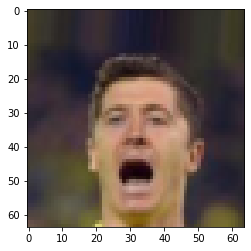

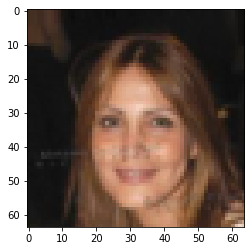

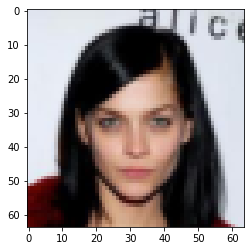

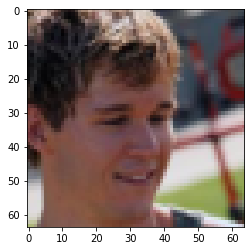

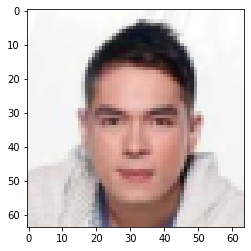

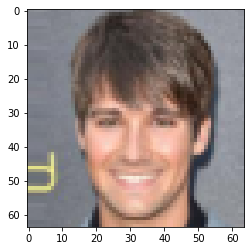

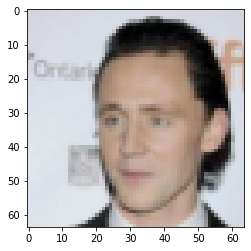

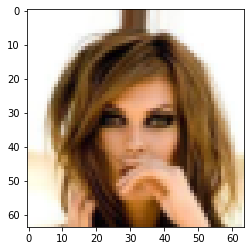

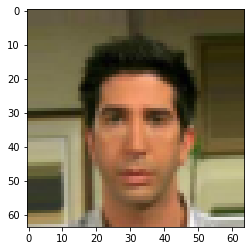

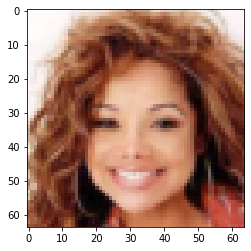

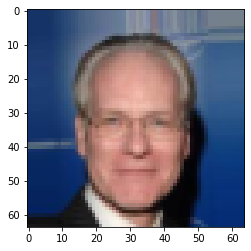

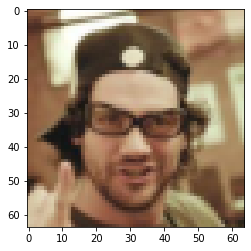

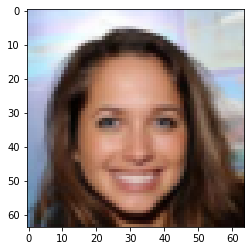

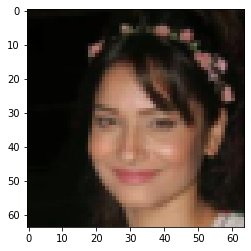

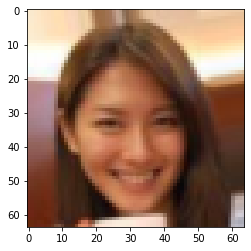

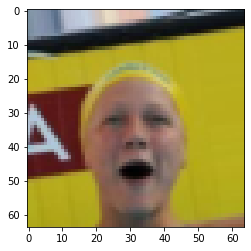

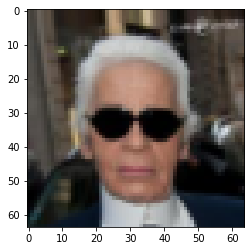

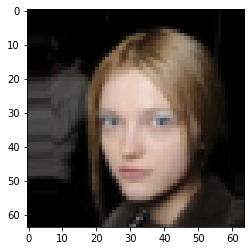

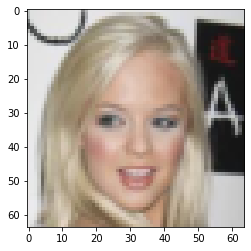

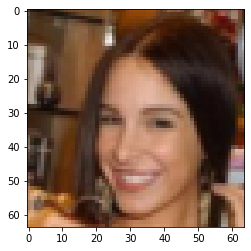

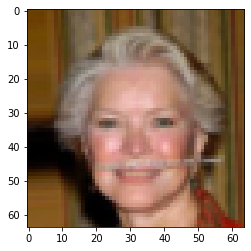

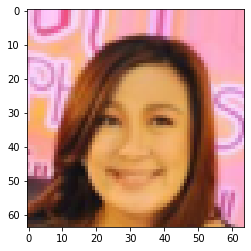

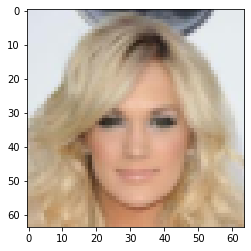

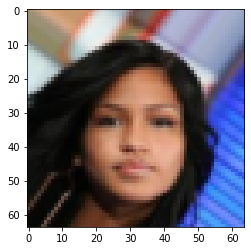

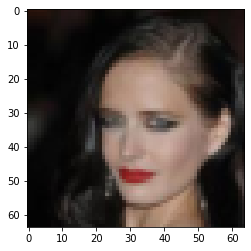

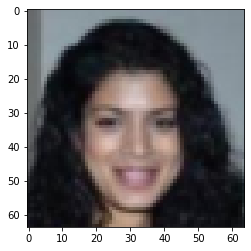

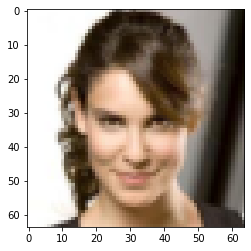

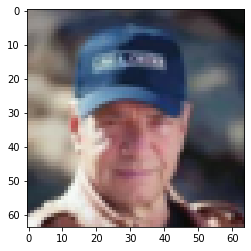

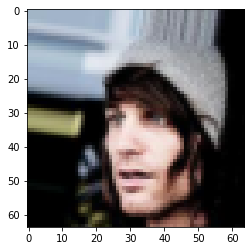

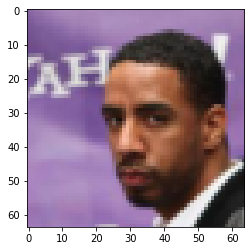

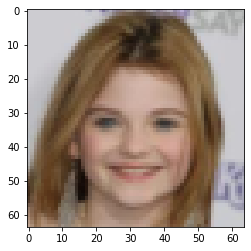

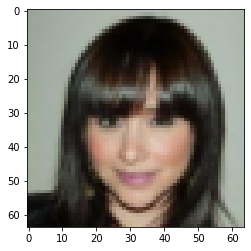

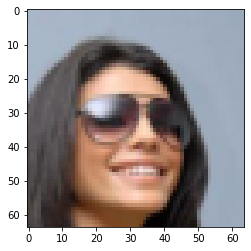

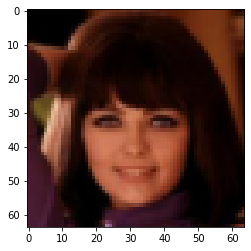

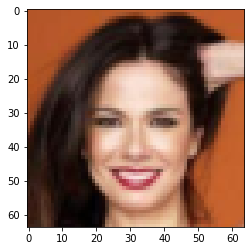

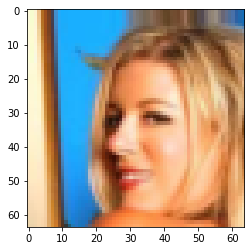

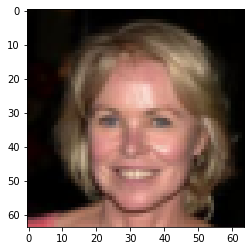

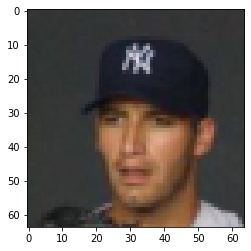

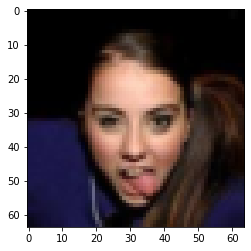

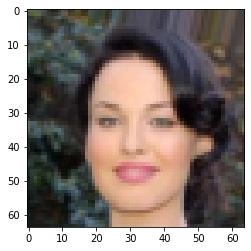

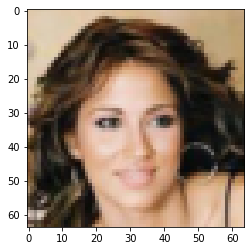

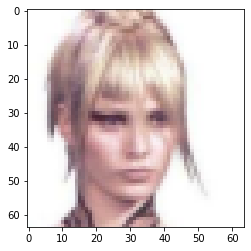

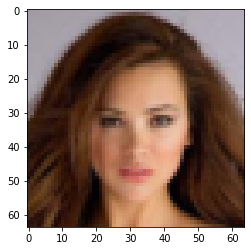

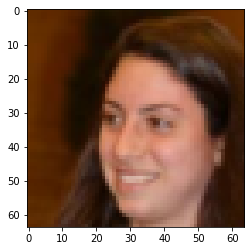

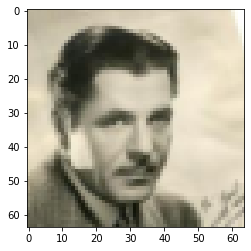

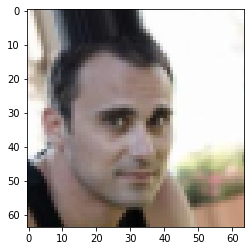

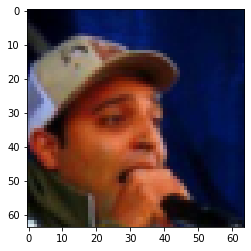

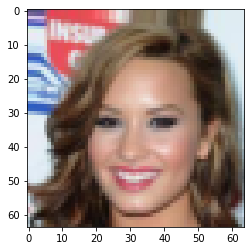

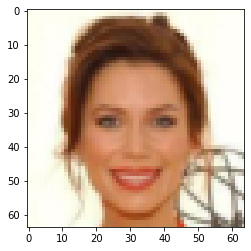

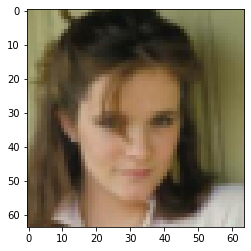

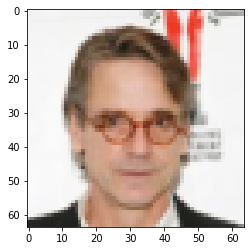

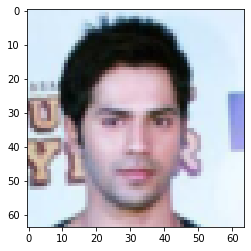

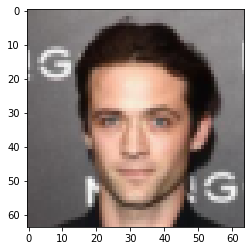

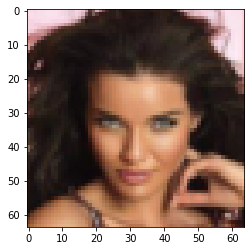

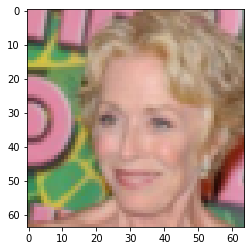

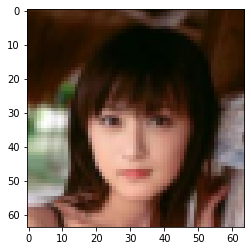

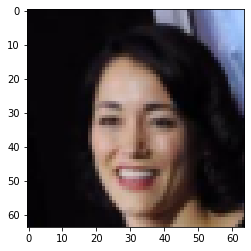

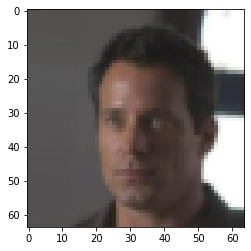

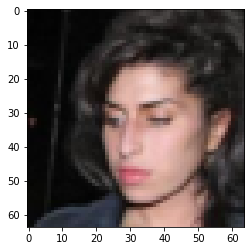

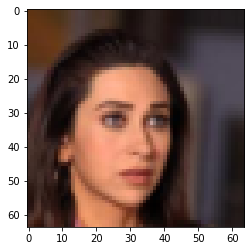

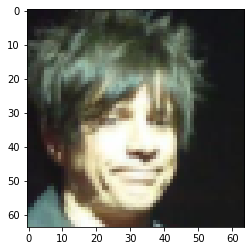

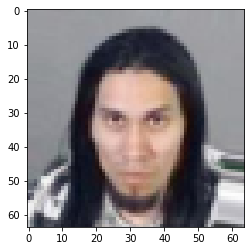

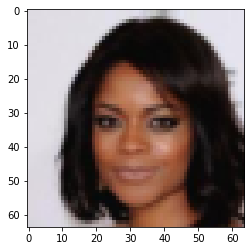

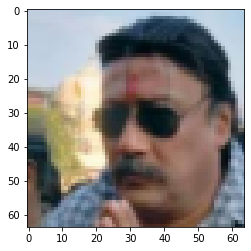

In [19]:
encoded, attributes = encode_model(netG)

In [56]:
# エンコードしたベクトルから画像を生成する
def decode_model(model, encoded):
    was_training = model.training # モデルが訓練されているかどうかをTrue or Falseで返す
    model.eval() # 評価モード
    #images_so_far = 0 # subplotに表示する際の、何番目の画像かを示す変数
    #fig = plt.figure()
    
    with torch.no_grad(): #autogradをオフにして推論を実施
        data = encoded
        #print(data)
        #real_cpu = data[0]
        #batch_size = real_cpu.size(0)
        #with torch.no_grad():
        #    input.resize_(real_cpu.size()).copy_(real_cpu)
        #print(data)
        #print(input)
            
        #encoded = netG.encoder(input)
        #sampled = netG.sampler(encoded)
        rec = netG.decoder(data)
        
        #print(sampled)
        
        for j in range(input.size()[0]):
            #print(sampled.cpu().data[j])
            #imshow(input.cpu().data[j])
            imshow(rec.cpu().data[j])
            #print(rec.cpu().data[j].numpy())
            # https://note.nkmk.me/python-opencv-imread-imwrite/
            # https://note.nkmk.me/python-zero-padding/
            out = rec.cpu().data[j].numpy().transpose((1,2,0))
            #print(type(out))
            #img = trans_out[0].cpu().numpy().transpose((1,2,0))
            
            # 画像保存のために値を変換する
            mean = np.array([0.5,0.5,0.5])
            std = np.array([0.5, 0.5, 0.5])
            img = std * out + mean
            img = np.clip(img, 0, 1)
            # 画像を適切に出力するためには値の範囲を0,255にする
            # https://teratail.com/questions/176352
            img = np.clip(img*255, 0, 255).astype(np.uint8)
            # matplotlibで保存する場合はimsaveを使う
            # https://sabopy.com/py/matplotlib-24/
            plt.imsave("output_transition/transition_{}.png".format(str(j).zfill(3)),img)
            
    model.train(mode=was_training) # モデルのモードをもとに戻す
    return(rec)

In [57]:
# https://discuss.pytorch.org/t/how-to-turn-a-list-of-tensor-to-tensor/8868/5
mixed = [encoded[0]*(1-x) + encoded[1]*x for x in torch.arange(0,1,1/64)]
mixed = torch.stack(mixed)

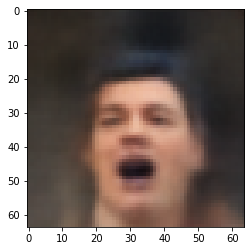

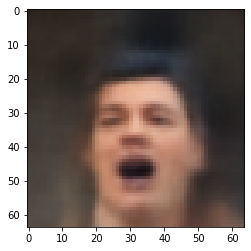

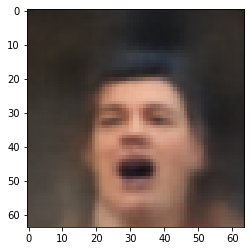

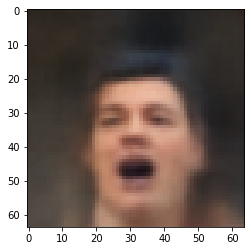

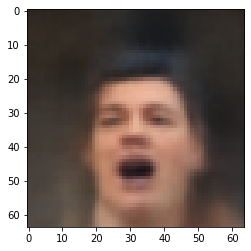

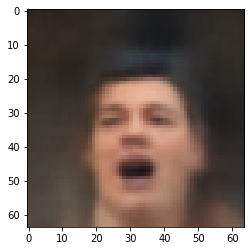

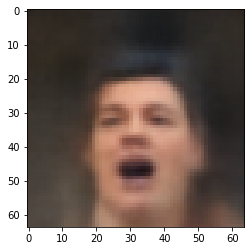

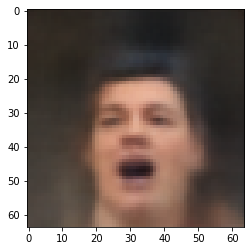

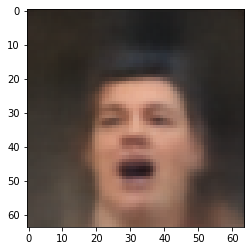

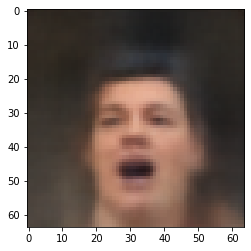

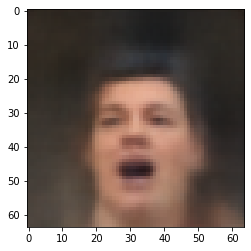

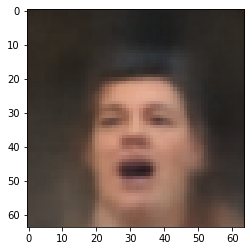

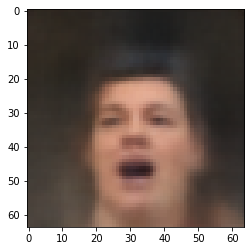

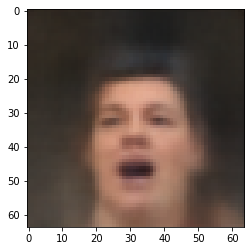

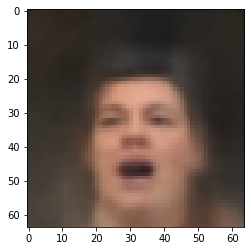

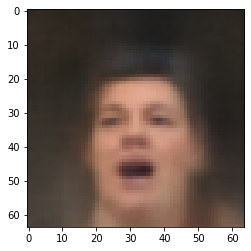

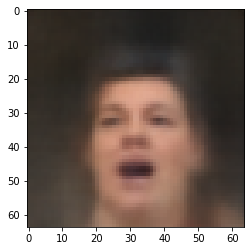

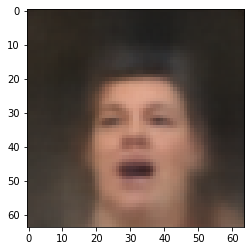

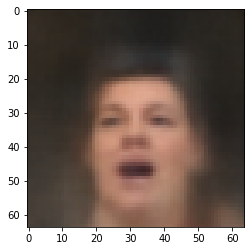

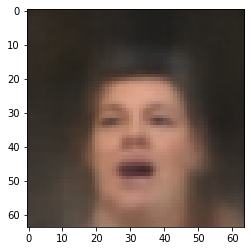

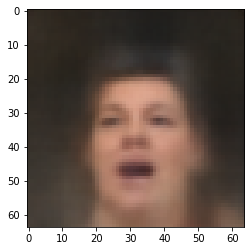

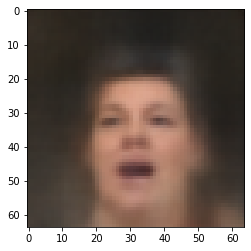

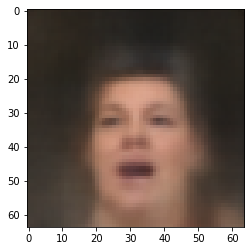

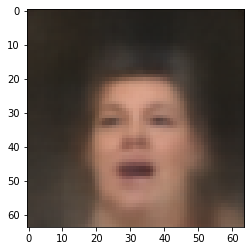

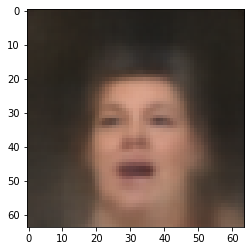

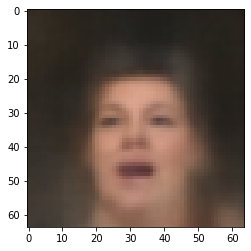

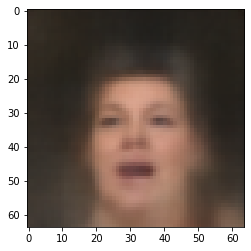

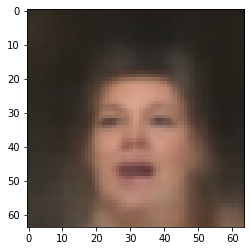

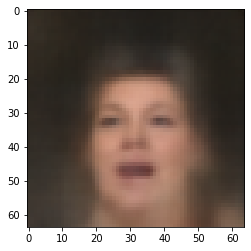

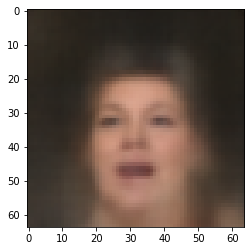

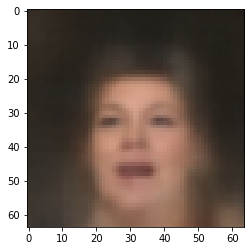

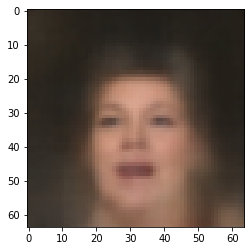

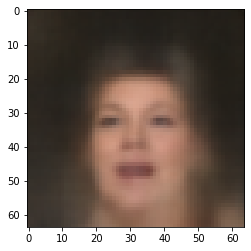

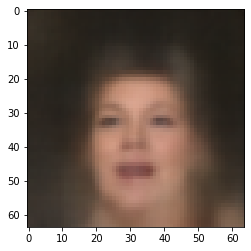

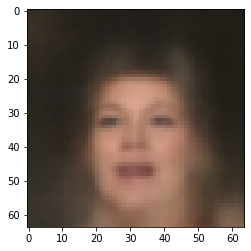

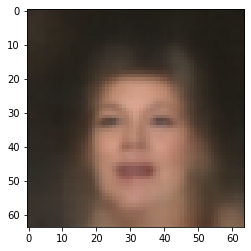

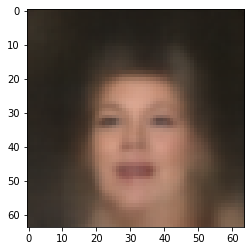

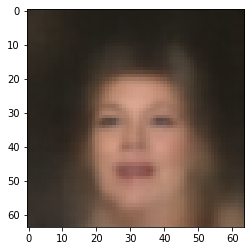

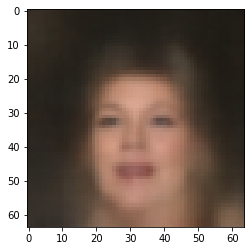

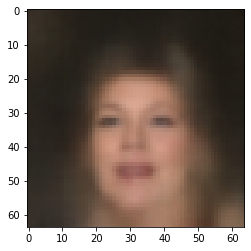

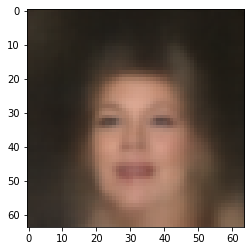

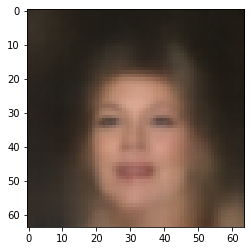

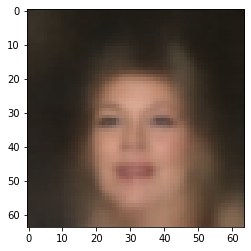

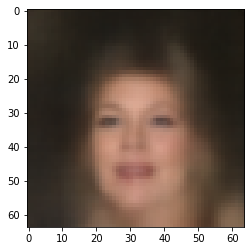

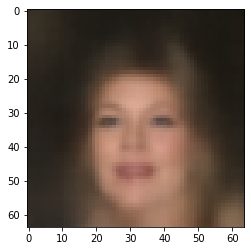

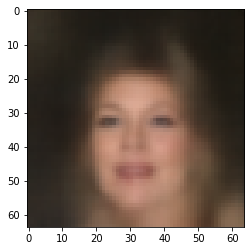

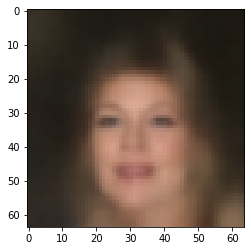

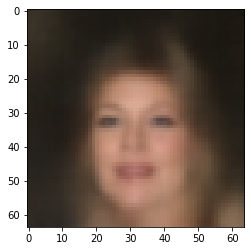

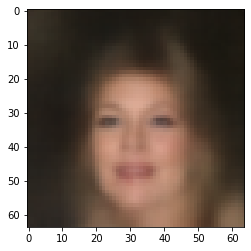

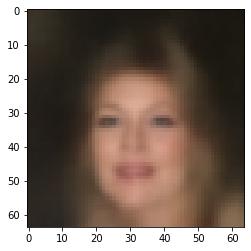

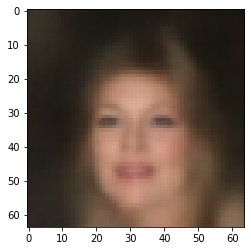

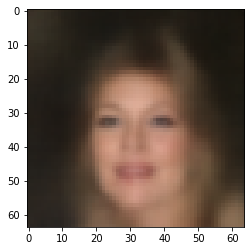

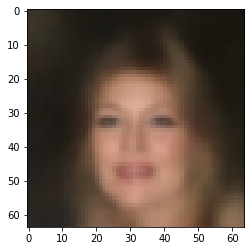

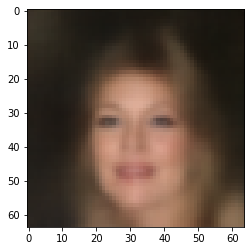

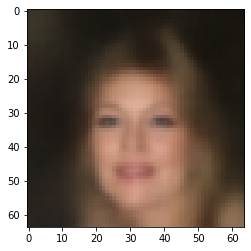

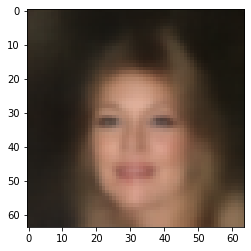

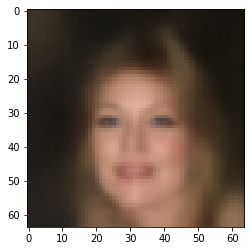

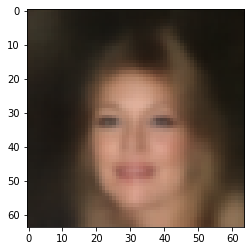

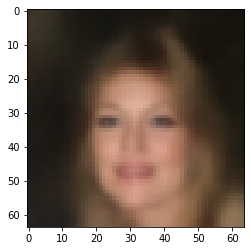

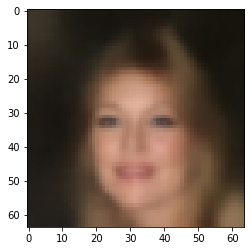

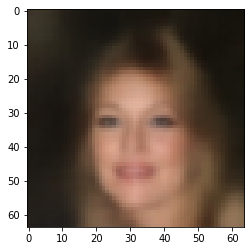

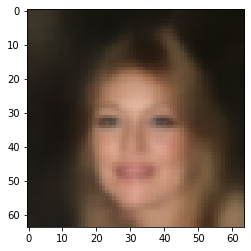

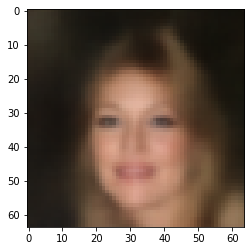

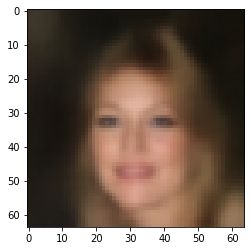

In [58]:
#decode_model(netG, mixed)
trans_out = decode_model(netG, mixed)